# Antiderivative SpectralSVR (Proof of concept)

In [1]:
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from skripsi_program import (
    SpectralSVR,
    FourierBasis,
    StandardScaler,
    Antiderivative,
)
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    }
)

In [3]:
# Set seed
generator = torch.Generator().manual_seed(42)
# domain
domain = slice(0, 2, 500)
# Generate functions/data
n_coeffs = 5000
modes = 100
u0 = 0  # integration constant
problem = Antiderivative()
u_clean, f_clean = problem.generate(
    FourierBasis, n_coeffs, modes, u0, generator=generator, periods=2
)

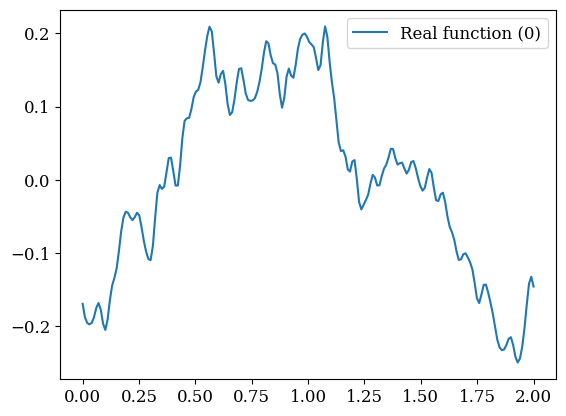

In [4]:
u_clean.plot()

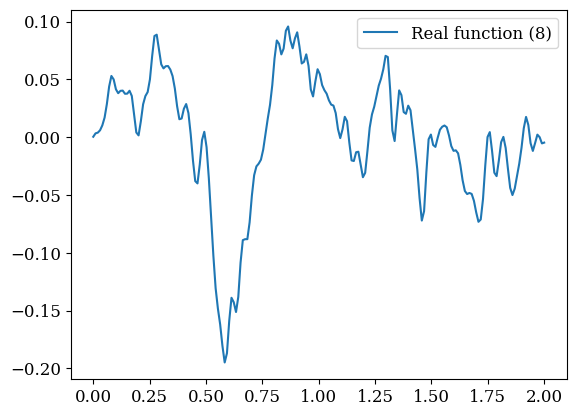

In [5]:
u_clean[1:10].plot(i=8)

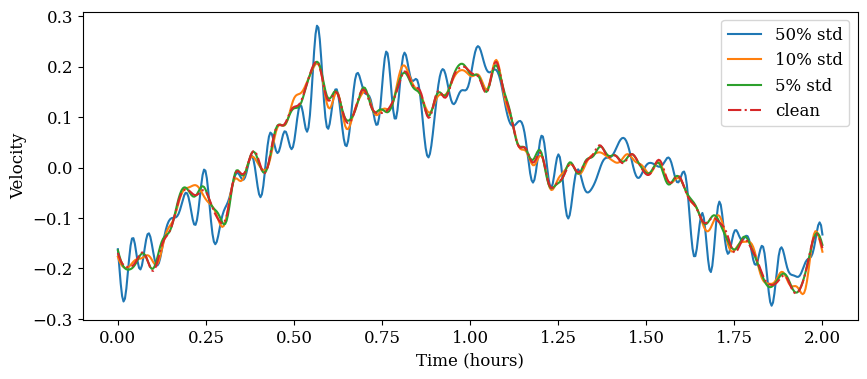

(100,)

In [6]:
# Add noise 1%
u_5 = u_clean.perturb(std_ratio=0.05, generator=generator)
f_5 = f_clean.perturb(std_ratio=0.05, generator=generator)
# Add noise 10%
u_10 = u_clean.perturb(std_ratio=0.10, generator=generator)
f_10 = f_clean.perturb(std_ratio=0.10, generator=generator)
# Add noise 50%
u_50 = u_clean.perturb(std_ratio=0.50, generator=generator)
f_50 = f_clean.perturb(std_ratio=0.50, generator=generator)


plt.figure(figsize=(10, 4))
u_50.plot(res=domain)
u_10.plot(res=domain)
u_5.plot(res=domain)
u_clean.plot(res=domain, linestyle="-.")
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
plt.legend(["50% std", "10% std", "5% std", "clean"], loc="upper right")
save_to_pgf("clean_perturbed_solution.pgf")
plt.show()
f_50.modes

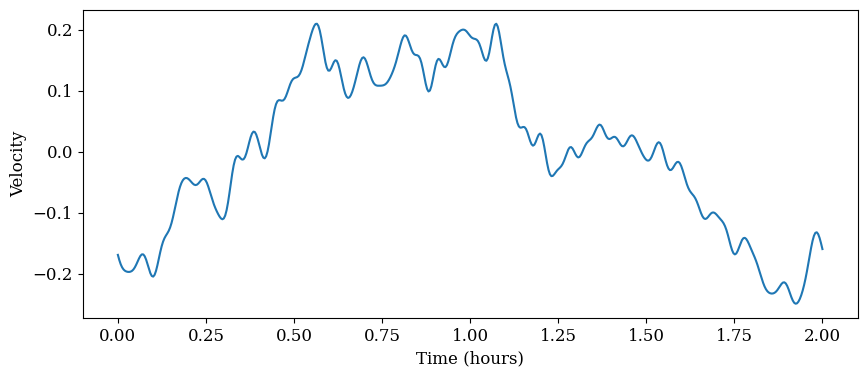

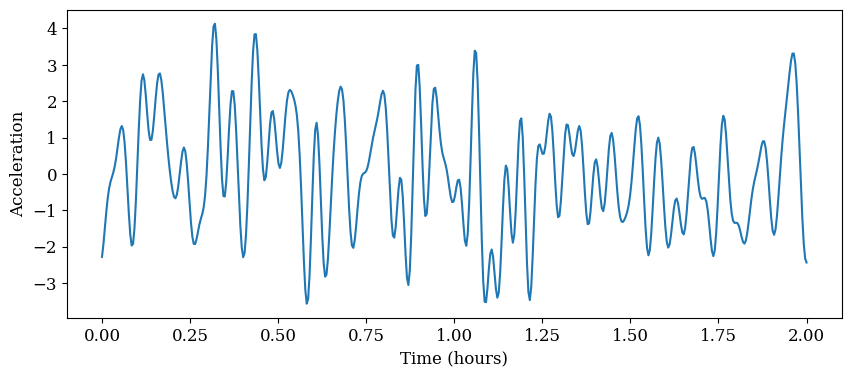

In [7]:
plt.figure(figsize=(10, 4))
u_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Velocity")
save_to_pgf("antiderivative_clean_0.pgf")
plt.show()
plt.figure(figsize=(10, 4))
f_clean.plot(i=0, res=domain, legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Acceleration")
save_to_pgf("derivative_clean_0.pgf")
plt.show()

In [8]:
# Train-test split
f_basis = f_50
u_basis = u_50
# Interpolate f & u
t = FourierBasis.grid(res=domain)
f = f_basis(t)
f = f.real

u = u_basis(t)
u = u.real
# df = TensorDataset(f, u, u_fourier.coeff)
df = TensorDataset(f, f_basis.coeff, u, u_basis.coeff)
df_train, df_test = random_split(
    df, (0.8, 0.2), generator=generator
)  # Scale inputs based on training inputs
f_train, f_coeff_train, u_train, u_coeff_train = df_train[:]
# f_input_train = f_train
f_input_train = f_coeff_train
scaler = StandardScaler().fit(f_input_train)
f_input_train = scaler.transform(f_input_train)
f_test, f_coeff_test, u_test, u_coeff_test = df_test[:]
# f_input_test = f_test
f_input_test = f_coeff_test
f_input_test = scaler.transform(f_input_test)

In [9]:
# Train svm
periods = (domain.stop - domain.start,)
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=1.0,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    verbose=None,
)
model.train(f_input_train, u_coeff_train)

In [10]:
model.svr.kernel_params.get("sigma")

tensor(14.1439, device='cuda:0')

In [11]:
# Test
model.test(f_input_test, u_coeff_test), model.test(f_input_test, u_clean.coeff[df_test.indices])

({'spectral': {'mse': 0.1532306969165802,
   'rmse': 0.39144691824913025,
   'mae': 0.27489548921585083,
   'r2': 0.21925102174282074,
   'smape': 1.3143795728683472,
   'rse': 0.7807493805885315,
   'rrse': 0.8672613501548767,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.003055301494896412,
   'rmse': 0.055274780839681625,
   'mae': 0.04410810396075249,
   'r2': 0.6290340423583984,
   'smape': 0.9351305961608887,
   'rse': 0.37096595764160156,
   'rrse': 0.6089217662811279,
   'pred_nan_sum': 0}},
 {'spectral': {'mse': 0.07064629346132278,
   'rmse': 0.26579371094703674,
   'mae': 0.11593017727136612,
   'r2': 0.6199550032615662,
   'smape': 0.8865017294883728,
   'rse': 330187.96875,
   'rrse': 58.053157806396484,
   'pred_nan_sum': 0},
  'function value': {'mse': 0.0014126377645879984,
   'rmse': 0.037585072219371796,
   'mae': 0.030007021501660347,
   'r2': 0.7863976955413818,
   'smape': 0.7641310095787048,
   'rse': 0.21360228955745697,
   'rrse': 0.4620564579963684,
   '

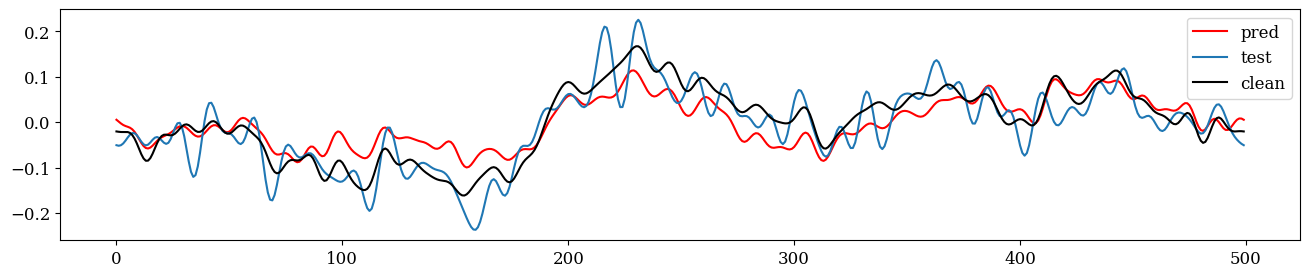

In [12]:
u_pred = model.forward(f_input_test, t, periods=periods).real
plt.figure(figsize=(16, 3))
# plt.plot(f_fourier[df_test.indices[0]](s).real[0], color="k")
i = 3
plt.plot(u_pred[i], color="r")
plt.plot(u_test[i])
plt.plot(u_clean[df_test.indices[i]](t)[0].real, color="k")
plt.legend(["pred","test","clean"])

(torch.Size([4000, 200]),
 torch.return_types.sort(
 values=tensor([-5.6954, -5.2397, -5.1862,  ...,  5.3080,  5.4654,  5.6542]),
 indices=tensor([ 170, 1903, 3371,  ..., 1421, 3482, 2737])))

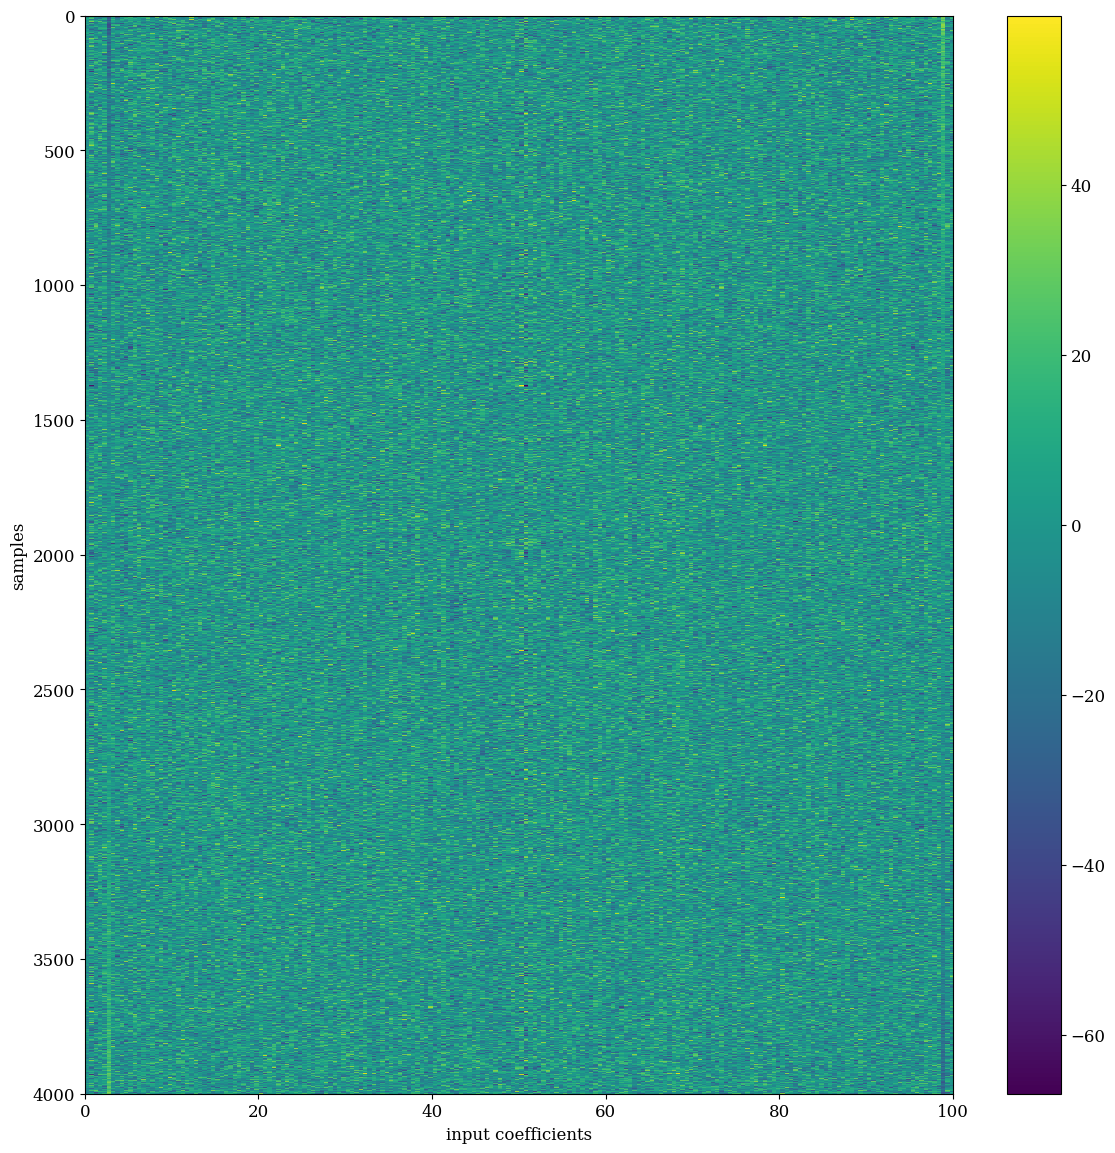

In [13]:
corr = model.svr.get_correlation_image().cpu()
sorted = u_coeff_train.real[:,2].sort()
plt.figure(figsize=(14, 14))
plt.imshow(corr[sorted.indices.cpu(), :], interpolation="none", aspect="auto",extent=(0,modes,corr.shape[0],0))
plt.ylabel("samples")
plt.xlabel("input coefficients")
plt.colorbar()
corr.shape, sorted


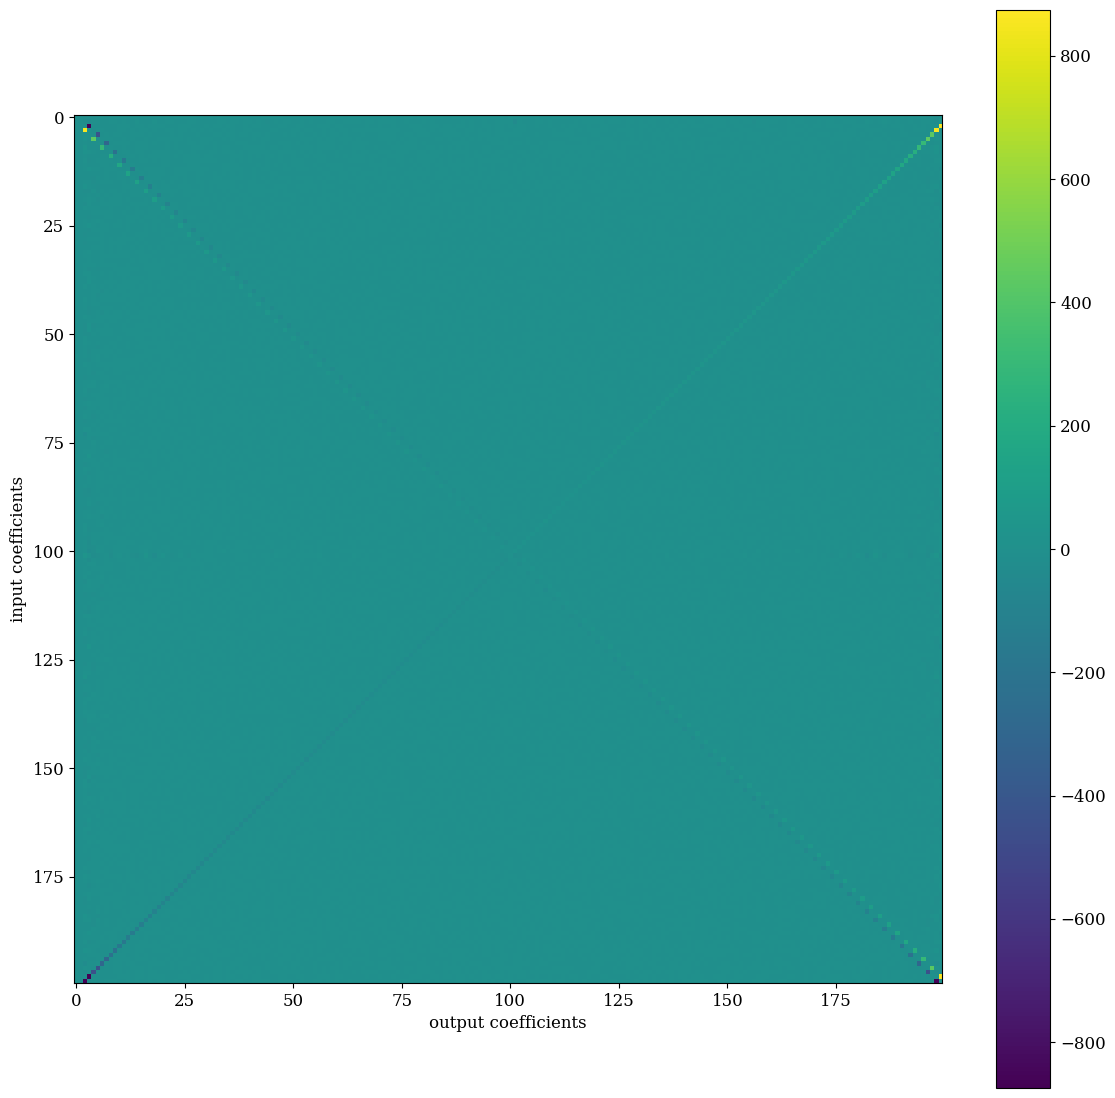

In [14]:
p_mat = model.svr.get_p_matrix().cpu()
plt.figure(figsize=(14,14))
plt.imshow(p_mat[:,:], interpolation="none", aspect="equal")
# plt.imshow(p_mat[:,2][:,None], interpolation="none", aspect="auto", extent=(0,10,0,10))
plt.colorbar()
plt.xlabel("output coefficients")
plt.ylabel("input coefficients")
plt.show()

In [15]:
u_clean[0].coeff, u_clean[0].grad().coeff

(tensor([[ 0.0000e+00+0.0000e+00j, -7.7860e+00-3.1049e+00j,
          -1.7923e+00+5.5923e-01j, -9.5106e-01-6.8978e-01j,
           1.4463e+00-5.7522e-01j, -9.5140e-01-1.4036e-01j,
          -1.3607e-03-1.1068e-01j,  2.0405e-01+8.6672e-01j,
           3.7748e-01-3.1611e-01j,  2.4063e-01+4.0849e-01j,
           6.0080e-01+3.8040e-01j,  3.8636e-01+9.9594e-04j,
           2.2055e-01-2.4664e-01j, -1.1978e-01-2.3997e-01j,
          -1.1494e-01+2.8593e-01j,  1.2118e-01-1.5564e-01j,
          -3.1288e-01+4.2017e-01j,  3.7221e-01+6.4272e-03j,
           3.8302e-02-7.5739e-02j, -5.0777e-02-3.9161e-02j,
           8.6322e-02+3.8918e-01j, -1.5150e-01+2.2243e-01j,
           2.5989e-01+3.8409e-01j, -2.0480e-01+1.6639e-01j,
          -1.5247e-01+5.2993e-02j,  3.7950e-02+5.8951e-02j,
           1.2135e-01+1.8916e-02j, -1.8228e-01-6.7124e-02j,
          -7.4152e-02+1.9099e-01j,  3.0126e-03+5.8220e-02j,
           6.0885e-02+3.5500e-02j,  3.3260e-02+2.1712e-01j,
           5.8932e-02-1.8194e-01j, -3.60

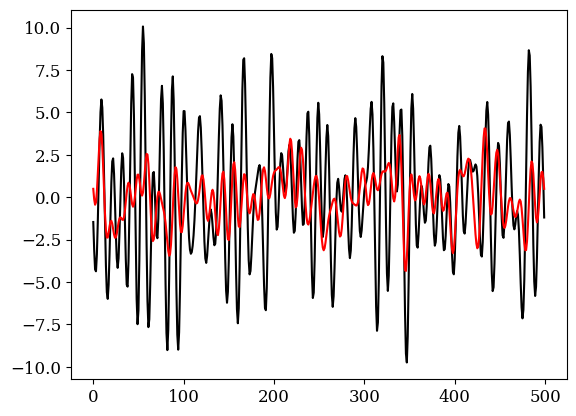

In [16]:
i= 0 
u_grad = torch.gradient(u_test[i], edge_order=2, spacing=t[1].sub(t[0]).item())[0]
plt.plot(u_grad, color="k")
# plt.plot(u_test[0])
plt.plot(f_test[i].real, color="r", linestyle="-")


In [17]:
# Test CPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cpu"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)


1.16 s ± 30 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
51.1 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
# Test GPU
model = SpectralSVR(
    FourierBasis(periods=periods), C=1.0, device=torch.device("cuda:0"), verbose=None
)
%timeit model.train(f_train, u_coeff_train)
%timeit model.test(f_test,u_coeff_test)

145 ms ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.3 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
